# DBSCAN

## DBSCAN 개요
- DBSCAN : Density Based Spatial Clustering of Applications with Noise
- 밀도 기반의 군집화 알고리즘
    - 특정 공간 내에 데이터 밀도 차이를 기반
- 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화 가능
- 복잡한 기하학적 분포도를 갖는 데이터 세트에 대해서도 군집화 가능

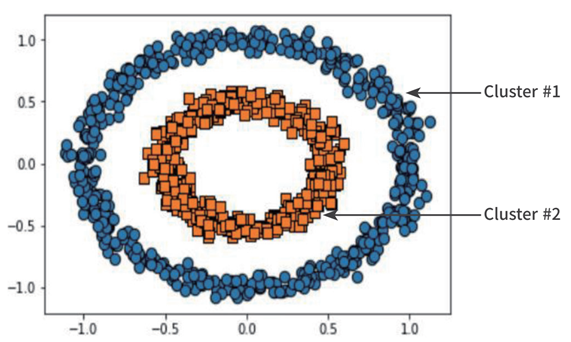

### DBSCAN을 구성하는 두 가지 파라미터
- Epsilon : 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
- min points : 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

**데이터 포인트 구분**

: 입실론 주변 영역 내 포함되는 최소 데이터 개수를 충족시키는 기준에 따라 구분
- 핵심 포인트(core point) 
    - 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우
- 이웃 포인트(neighbor point)
    - 주변 영역 내에 위치한 타 데이터
- 경계 포인트(border point)
    - 주변 영역 내에 최소 데이터 개수 이상의 이웃 포인터를 가지고 있지 않지만 핵심 포인트를 이웃 포인터로 가지고 있는 데이터
- 잡음 포인트(noise point)
    - 최소 데이터 개수 이상의 이웃 포인터를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트도 가지고 있지 않는 데이터


### DBSCAN 군집화 과정(사례)
: 최소데이터 개수는 6인 경우

1. p1~p12 까지 12개 데이터 세트
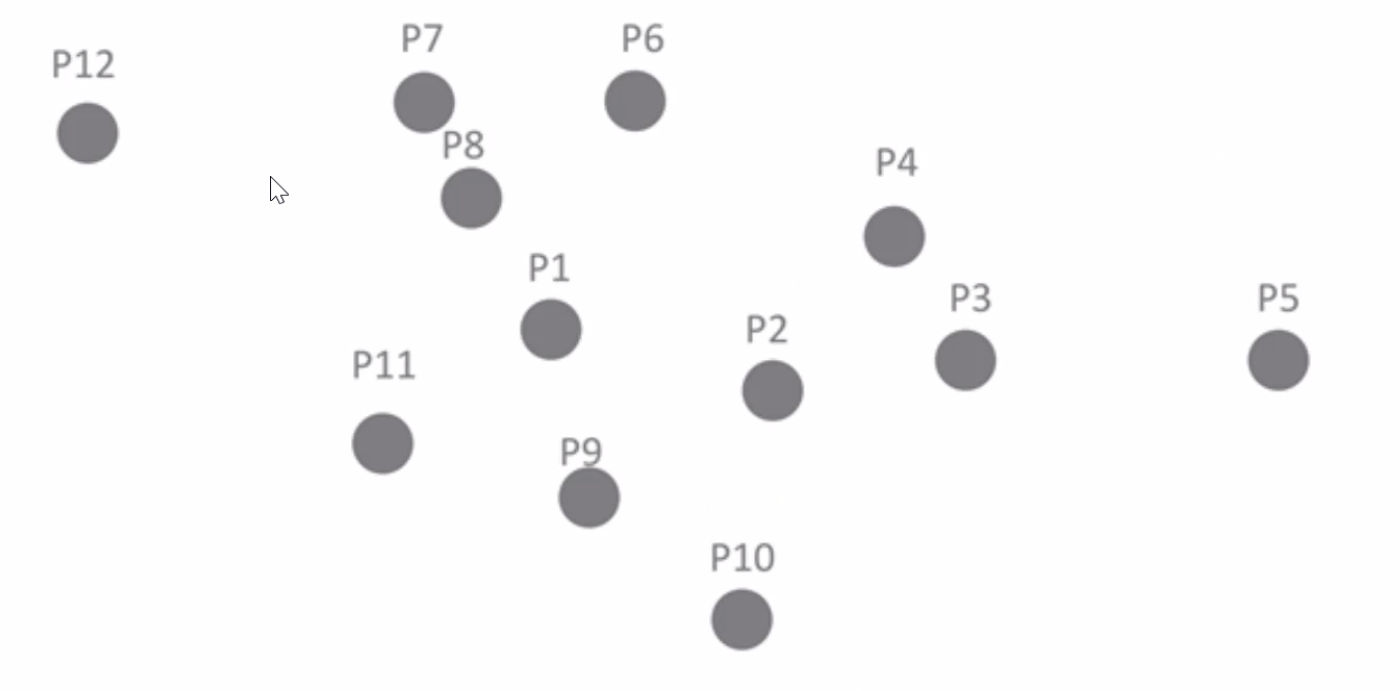


2. **p1** 데이터를 기준으로 입실론 반경 내에 포함된 데이터가 7개(자신p1, p2, p6, p7, p8, p9, p11)로 최소 데이터 5개 이상을 만족하므로 p1은 **`핵심 포인트`** 이다
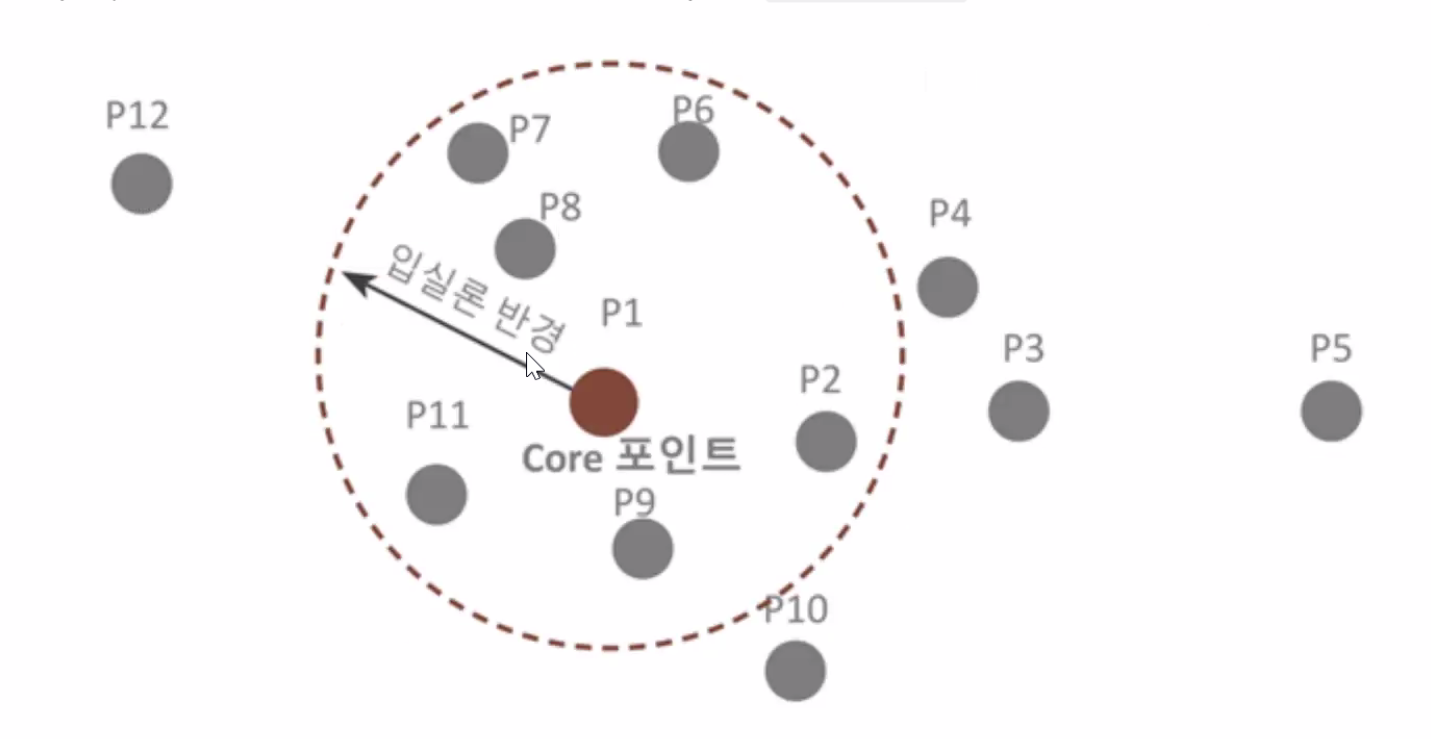


3. **p2** 데이터 포인트는 반경 내에 6개 데이터(p2, 이웃데이터 p1, p3, p4, p9, p10)를 가지고 있으므로 **`핵심 포인트`** 이다
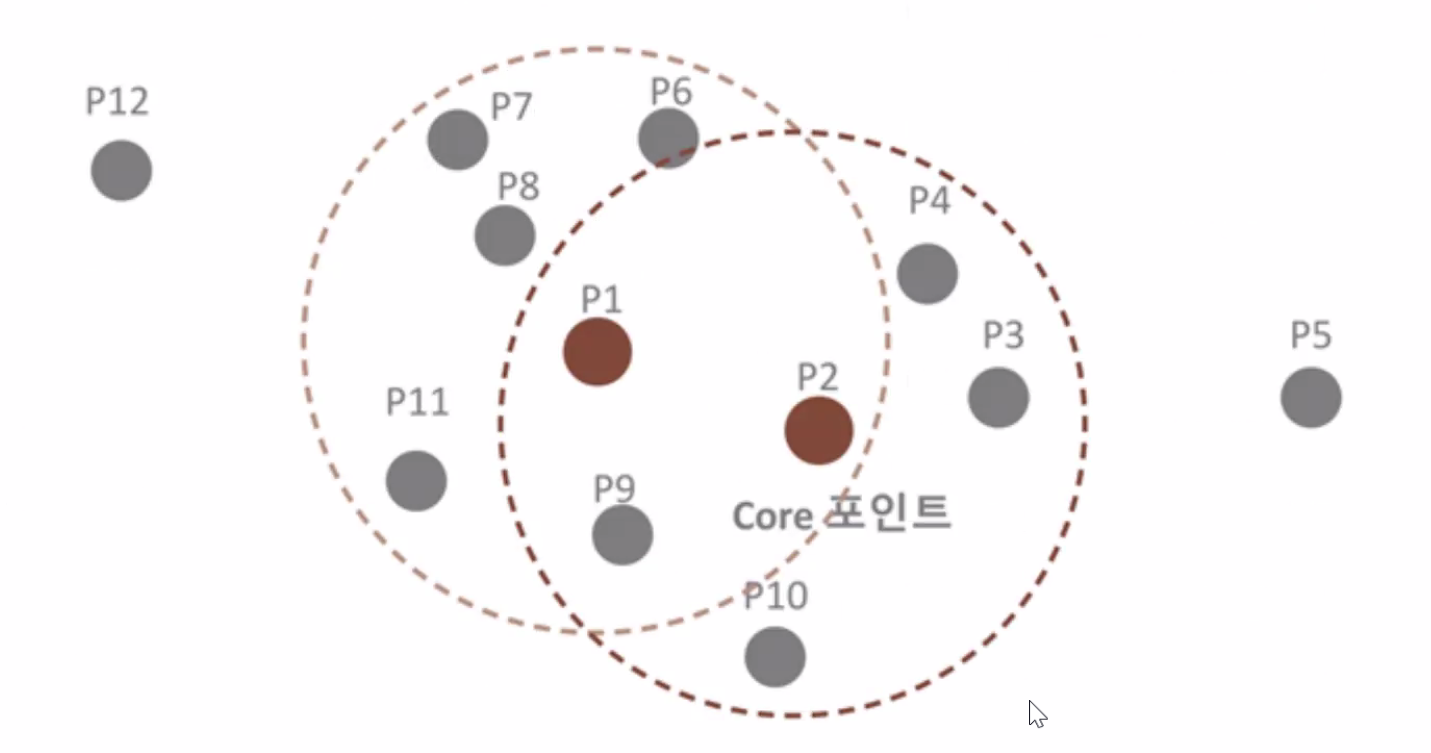


4. 핵심포인트 p1의 이웃 데이터 포인트 p2 역시 핵심포인트일 경우 p1에서 p2로 **연결해 직접 접근이 가능** 하다.
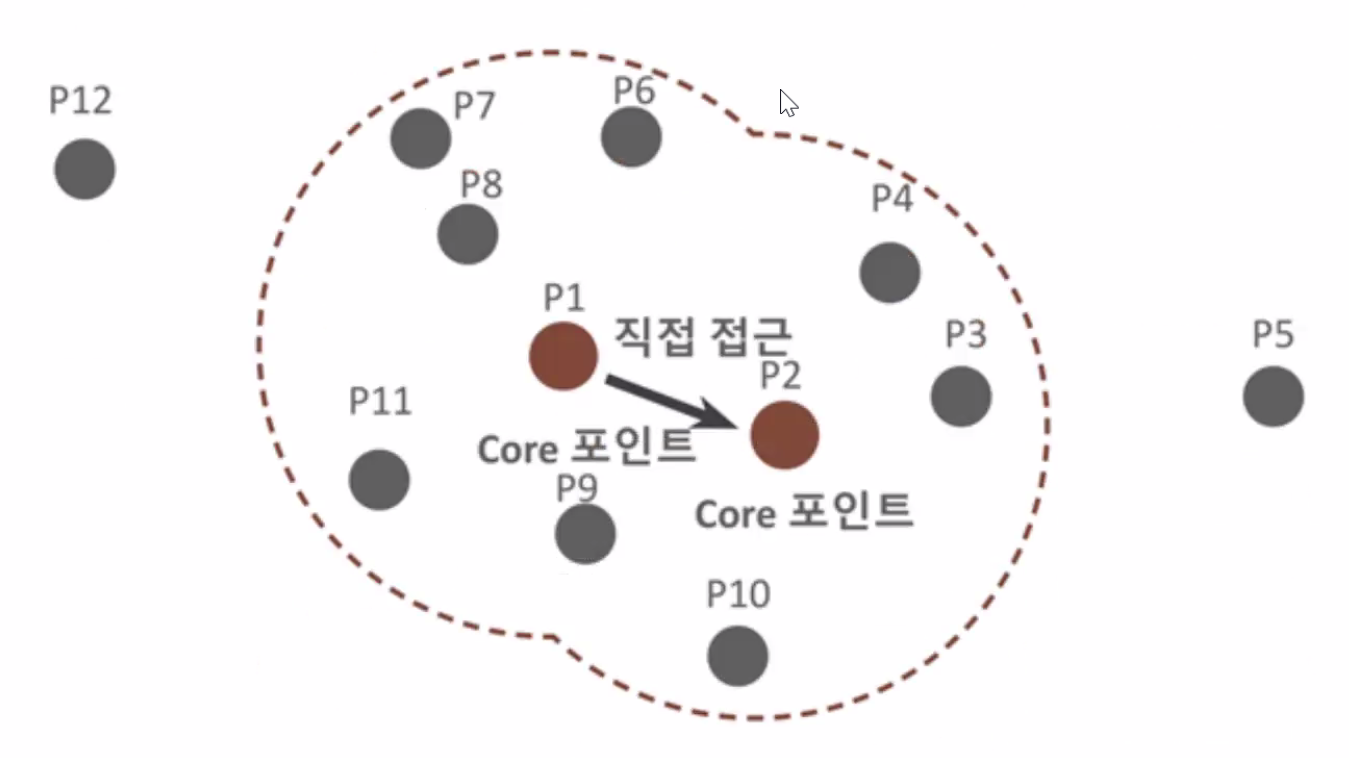

5. 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심포인트를 서로 연결하면서 군집화를 구성한다. 이러한 방식으로 점차적으로 군집(cluster) 영역을 확장해 나간다(=> **`DBSCAN 군집화 방식`** )
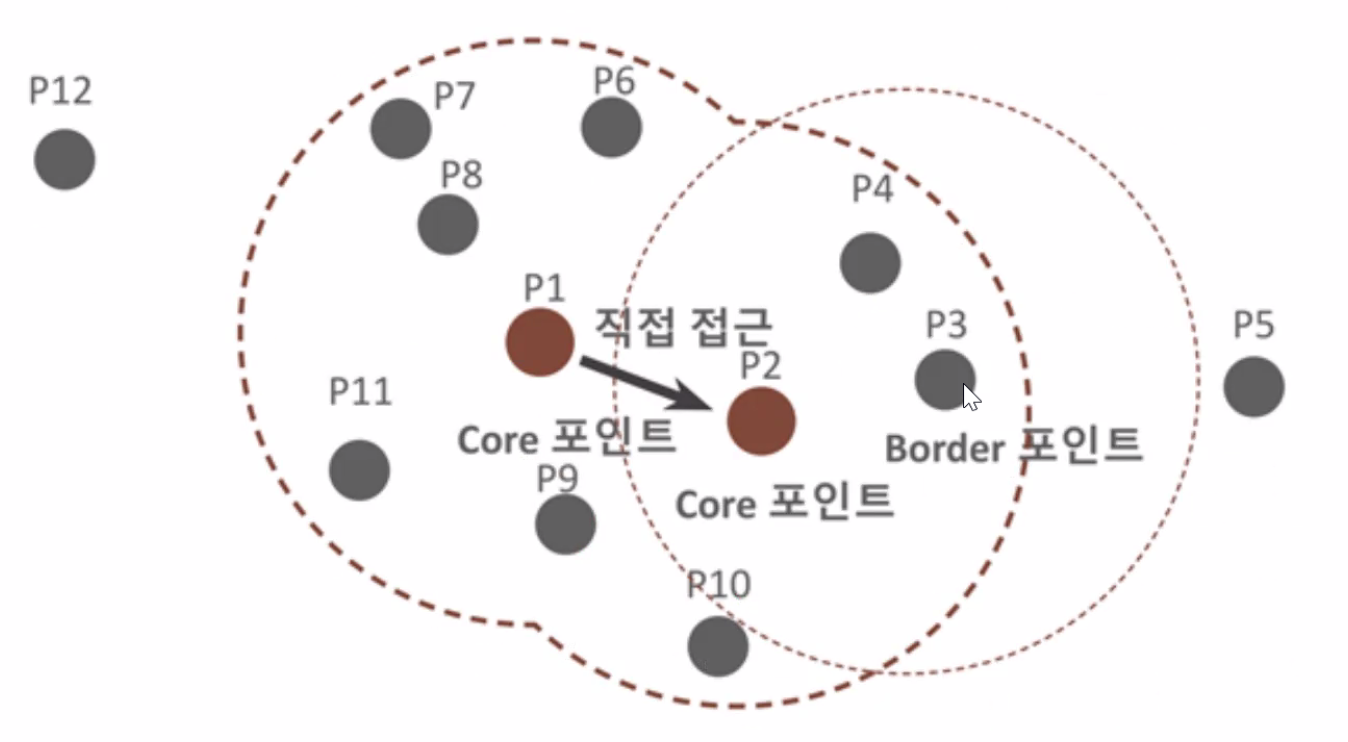

6. **p3** 데이터의 경우 반경 내에 포함되는 이웃 데이터는 p2, p4로 군집으로 분류할 수 있는 핵심 포인트가 되지 못한다. 그러나 이웃 데이터 중 핵심 포인트 p2를 가지고 있으므로 **`경계 포인트`** 가 되며 군집의 외곽을 형성한다.
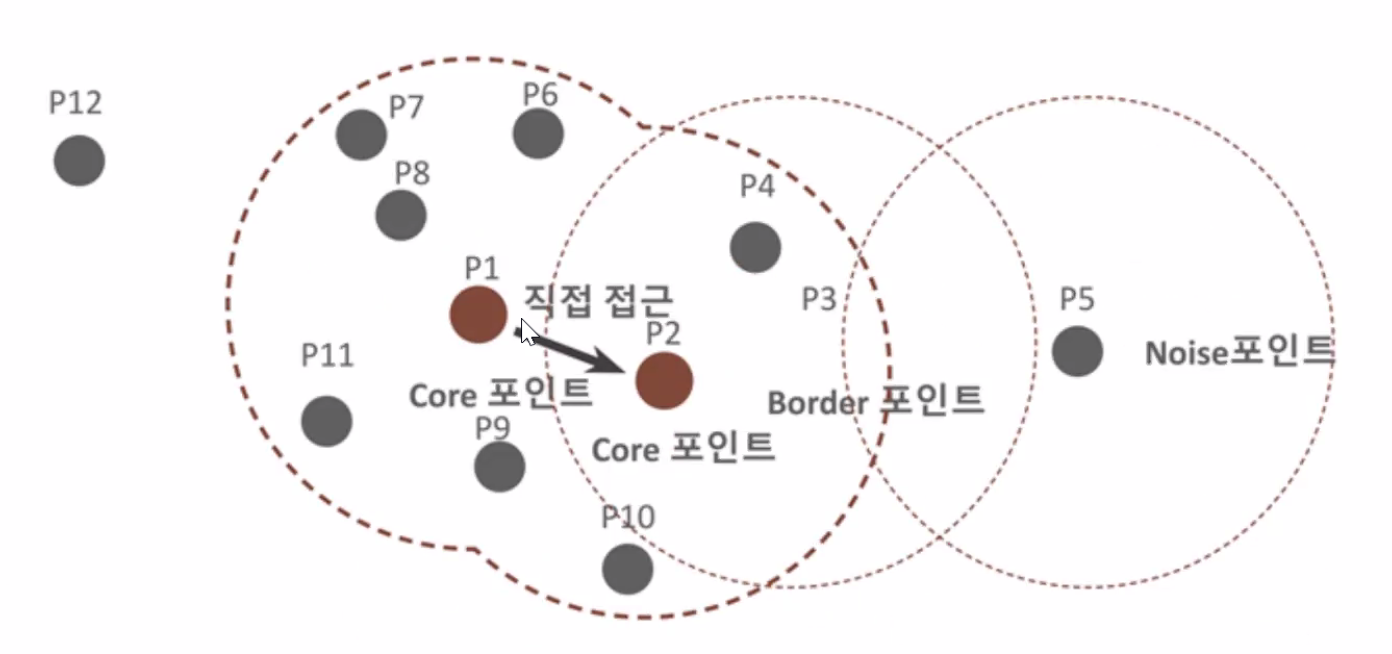


7. **p5**와 같이 반경 내에 최소 데이터를 가지고 있지 않고 핵심 포인트를 이웃 포인트로 가지고 있지 않는 데이터는 **`잡음 포인터`** 이다. 


### 사이킷런에서 DBSCAN 클래스 `DBSCAN`

DBSCAN 초기화 파라미터
- eps : 입실론 주변 영역의 반경
- min_samples : 핵심포인트가 되기 위한 입실론 주변 영역 내에 포함될 데이터의 최소 개수(자신의 데이터 포함)

### DBSCAN 적용하기 – 붓꽃 데이터 셋

In [1]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [6]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6 , min_samples=8 , metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
np.unique(dbscan_labels , return_counts=True)

# 군집 레이블이 -1인 것은 노이즈에 속하는 군집을 의미
# Target 값의 유형이 3가지인데, 군집이 2개가 됐다고 군집화 효율이 떨어진다는 의미는 아니다
# DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정하므로 DBSCAN에서 군집의 개수를 지정하는 것은 무의미 하다

(array([-1,  0,  1], dtype=int64), array([13, 49, 88], dtype=int64))

In [8]:
irisDF.groupby(['target'])['dbscan_cluster'].value_counts()

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64

=> DBSCAN 군집화 결과 0과 1 두 개의 군집으로 군집화 됨 
- 군집레이블 -1 은 노이즈에 속하는 군집

In [9]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 
### 클러스터링 결과를 시각화하는 함수

def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

**PCA를 적용하여 2차원 데이터 세트로 변환 후 DBSCAN 군집화 결과 시각화**

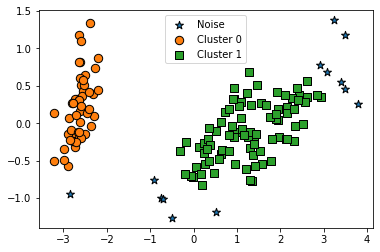

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2 , random_state=0)
pca_transform = pca.fit_transform(iris.data)

irisDF['ftr1'] = pca_transform[:,0]
irisDF['ftr2'] = pca_transform[:,1]

visualize_cluster_plot(dbscan , irisDF , 'dbscan_cluster' , iscenter=False)

**eps를 0.6에서 0.8로 변경**

eps = 0.8
(array([-1,  0,  1], dtype=int64), array([ 3, 50, 97], dtype=int64))


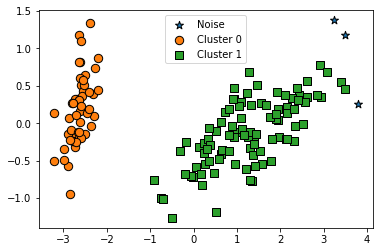

In [19]:
dbscan = DBSCAN(eps = 0.8 , min_samples=8 , metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
np.unique(dbscan_labels , return_counts=True)
print('eps = 0.8')

print(np.unique(dbscan_labels , return_counts=True))
irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
visualize_cluster_plot(dbscan , irisDF , 'dbscan_cluster' , iscenter=False)

0.6 -> 0.8 : 노이즈 줄어듬

**eps=0.6, min_samples=16일 경우**

eps = 0.8
(array([-1,  0,  1], dtype=int64), array([22, 48, 80], dtype=int64))


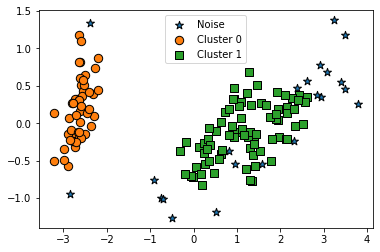

In [20]:
dbscan = DBSCAN(eps = 0.6 , min_samples=16 , metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
np.unique(dbscan_labels , return_counts=True)
print('eps = 0.8')

print(np.unique(dbscan_labels , return_counts=True))
irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
visualize_cluster_plot(dbscan , irisDF , 'dbscan_cluster' , iscenter=False)

### DBSCAN 적용하기 – make_circles() 데이터 세트

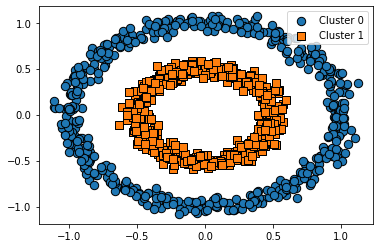

In [21]:
# 복잡한 기하학적 분포를 가지는 데이터 세트에서 DBSCAN과 알고리즘 비교를 위해 데이터 샘플 생성

from sklearn.datasets import make_circles

X , y = make_circles(n_samples=1000 , shuffle=True , noise=0.05 , random_state=0 , factor=0.5)

clusterDF = pd.DataFrame(data=X , columns=['ftr1' , 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF , 'target' , iscenter=False)

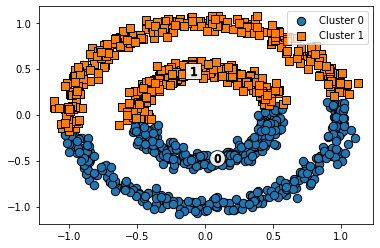

In [22]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2 , max_iter=1000 , random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_labels'] = kmeans_labels
visualize_cluster_plot(kmeans, clusterDF, 'kmeans_labels' , iscenter=True)

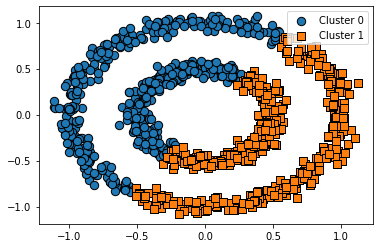

In [25]:
# GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2 , random_state=0)
gmm_labels = gmm.fit(X).predict(X)

clusterDF['gmm_labels'] = gmm_labels
visualize_cluster_plot(gmm, clusterDF, 'gmm_labels' , iscenter=False)

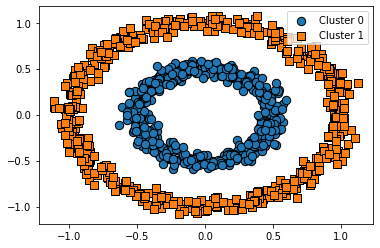

In [26]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
dbscan = DBSCAN(eps=0.2 , min_samples=10 , metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_labels'] = dbscan_labels
visualize_cluster_plot(dbscan, clusterDF, 'dbscan_labels' , iscenter=False)